In [1]:
!pip install seqeval iterative-stratification

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=5a5bfc2c27b0f92d363980e5ca112c97dee4b81cd35e9d6c4a22958cef53b51e
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [2]:
# !rm -rf /kaggle/working/ner_xlmr_wordlevel_entity

In [3]:
# -*- coding: utf-8 -*-
import os
import re
import ast
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from typing import List, Tuple
from datasets import Dataset, Features, Sequence, Value
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
)
from seqeval.metrics import f1_score, classification_report

# -----------------------
# 0) Сиды и CUDA
# -----------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

# -----------------------
# 1) Данные
# -----------------------
TRAIN_PATH = "/kaggle/input/1-million-clen-aug-correct-coffee/1_million_clen_aug_correct_coffee/train_clean_aug_correct_coffee.csv"
df = pd.read_csv(TRAIN_PATH, sep=";", encoding="utf-8")
df.columns = df.columns.str.strip().str.replace("\ufeff", "", regex=True)
df["annotation"] = df["annotation"].apply(ast.literal_eval)

# -----------------------
# 2) Метки
# -----------------------
LABELS = [
    "O",
    "B-TYPE", "I-TYPE",
    "B-BRAND", "I-BRAND",
    "B-VOLUME", "I-VOLUME",
    "B-PERCENT", "I-PERCENT",
]
label2id = {l: i for i, l in enumerate(LABELS)}
id2label = {i: l for i, l in enumerate(LABELS)}
ENTITY_TYPES = ["TYPE", "BRAND", "VOLUME", "PERCENT"]

# -----------------------
# 3) char-span → word-level BIO
# -----------------------
NONSPACE = re.compile(r"\S+")

def split_words_with_offsets(text: str) -> List[Tuple[str, int, int]]:
    return [(m.group(0), m.start(), m.end()) for m in NONSPACE.finditer(text)]

def spans_to_word_bio(text: str, spans: List[Tuple[int, int, str]]):
    words = split_words_with_offsets(text)
    tokens = [w for (w, _, _) in words]
    offsets = [(ws, we) for (_, ws, we) in words]
    bio = ["O"] * len(words)

    norm_spans = []
    for s, e, t in spans:
        if t in ("0", "O"):
            continue
        s = max(0, int(s))
        e = max(s, int(e))
        if s < e:
            norm_spans.append((s, e, t))
    norm_spans.sort(key=lambda x: (x[2], x[0], x[1]))

    prev_type = None
    for idx, (_, ws, we) in enumerate(words):
        best, best_len = None, 0
        for s, e, t in norm_spans:
            overlap = max(0, min(we, e) - max(ws, s))
            if overlap > best_len:
                best, best_len = (s, e, t), overlap
        if best is None:
            bio[idx] = "O"
            prev_type = None
            continue
        _, _, t = best
        ent_type = t.split("-", 1)[-1] if "-" in t else t
        if prev_type == ent_type and idx > 0 and bio[idx-1] != "O":
            bio[idx] = f"I-{ent_type}"
        else:
            bio[idx] = f"B-{ent_type}"
        prev_type = ent_type
    return tokens, bio, offsets

def df_to_wordlevel(df_in: pd.DataFrame) -> pd.DataFrame:
    tokens_col, tags_col, offsets_col, text_col = [], [], [], []
    for text, spans in zip(df_in["sample"], df_in["annotation"]):
        tks, bio, offs = spans_to_word_bio(text, spans)
        tokens_col.append(tks)
        tags_col.append(bio)
        offsets_col.append(offs)
        text_col.append(text)
    return pd.DataFrame({
        "tokens": tokens_col,
        "ner_tags": tags_col,
        "word_offsets": offsets_col,
        "text": text_col,
    })

train_wl = df_to_wordlevel(df)

# -----------------------
# 4) Токенизация
# -----------------------
MODEL_NAME = "xlm-roberta-large"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_and_align_labels(examples):
    tokenized = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        max_length=128,
    )
    all_labels, new_labels = examples["ner_tags"], []
    for i in range(len(all_labels)):
        word_ids = tokenized.word_ids(batch_index=i)
        labels, prev_wid = [], None
        for wid in word_ids:
            if wid is None:
                labels.append(-100)
            else:
                raw_tag = all_labels[i][wid]
                if wid != prev_wid:
                    labels.append(label2id[raw_tag])
                else:
                    if raw_tag == "O":
                        labels.append(-100)
                    else:
                        ent = raw_tag.split("-", 1)[1]
                        labels.append(label2id["I-" + ent])
                prev_wid = wid
        new_labels.append(labels)
    tokenized["labels"] = new_labels
    return tokenized

features = Features({
    "tokens": Sequence(Value("string")),
    "ner_tags": Sequence(Value("string")),
    "word_offsets": Sequence(Sequence(Value("int32"))),
    "text": Value("string"),
})

train_ds = Dataset.from_pandas(train_wl, features=features, preserve_index=False)
eval_word_offsets_ref = train_wl["word_offsets"].tolist()
eval_tokens_ref       = train_wl["tokens"].tolist()

train_ds = train_ds.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=["tokens", "ner_tags", "word_offsets", "text"]
)

# -----------------------
# 5) Модель
# -----------------------
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(LABELS),
    id2label=id2label,
    label2id=label2id,
)

# -----------------------
# 6) Trainer
# -----------------------
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, ignore_index=-100):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index)
    def forward(self, logits, labels):
        ce_loss = self.ce(logits.view(-1, logits.size(-1)), labels.view(-1))
        pt = torch.exp(-ce_loss)
        return ((1 - pt) ** self.gamma) * ce_loss

class FocalTrainerWithOffsets(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = FocalLoss()
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"]
        )
        logits = outputs.logits
        loss = self.loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

data_collator = DataCollatorForTokenClassification(tokenizer)

training_args = TrainingArguments(
    output_dir="./ner_xlmr_wordlevel_entity",
    save_strategy="steps",
    save_steps=500,
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    num_train_epochs=12,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    report_to="none",
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    ddp_find_unused_parameters=False,
    torch_compile=False,
    save_total_limit=2,
)

trainer = FocalTrainerWithOffsets(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

# -----------------------
# 7) Сохранение
# -----------------------
SAVE_DIR = "./ner_xlmr_wordlevel_entity_best"
os.makedirs(SAVE_DIR, exist_ok=True)

trainer.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)
print(f"HuggingFace модель сохранена в {SAVE_DIR}")

# TorchScript
class TokenClsWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, input_ids, attention_mask):
        return self.model(input_ids=input_ids, attention_mask=attention_mask).logits

wrapper = TokenClsWrapper(trainer.model).eval()
device = next(wrapper.parameters()).device
example_inputs = tokenizer("пример текста", return_tensors="pt", truncation=True, max_length=128)
example_inputs = {k: v.to(device) for k, v in example_inputs.items()}
with torch.no_grad():
    traced = torch.jit.trace(wrapper, (example_inputs["input_ids"], example_inputs["attention_mask"]), strict=False)
torch.jit.save(traced, os.path.join(SAVE_DIR, "model_torchscript.pt"))

# ONNX
torch.onnx.export(
    wrapper,
    (example_inputs["input_ids"], example_inputs["attention_mask"]),
    os.path.join(SAVE_DIR, "model.onnx"),
    input_names=["input_ids", "attention_mask"],
    output_names=["logits"],
    dynamic_axes={"input_ids": {0: "batch", 1: "seq"},
                  "attention_mask": {0: "batch", 1: "seq"},
                  "logits": {0: "batch", 1: "seq"}},
    opset_version=17,
    do_constant_folding=True,
)
print(f"TorchScript и ONNX сохранены в {SAVE_DIR}")

2025-09-27 14:02:57.416479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758981777.797059      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758981777.915929      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/30679 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_19/45865838.py:192: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FocalTrainerWithOffsets.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Step,Training Loss
100,1.435500
200,0.448200
300,0.074400
400,0.025800
500,0.017000
600,0.014000
700,0.011200
800,0.010000
900,0.006000
1000,0.006700


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


HuggingFace модель сохранена в ./ner_xlmr_wordlevel_entity_best
TorchScript и ONNX сохранены в ./ner_xlmr_wordlevel_entity_best


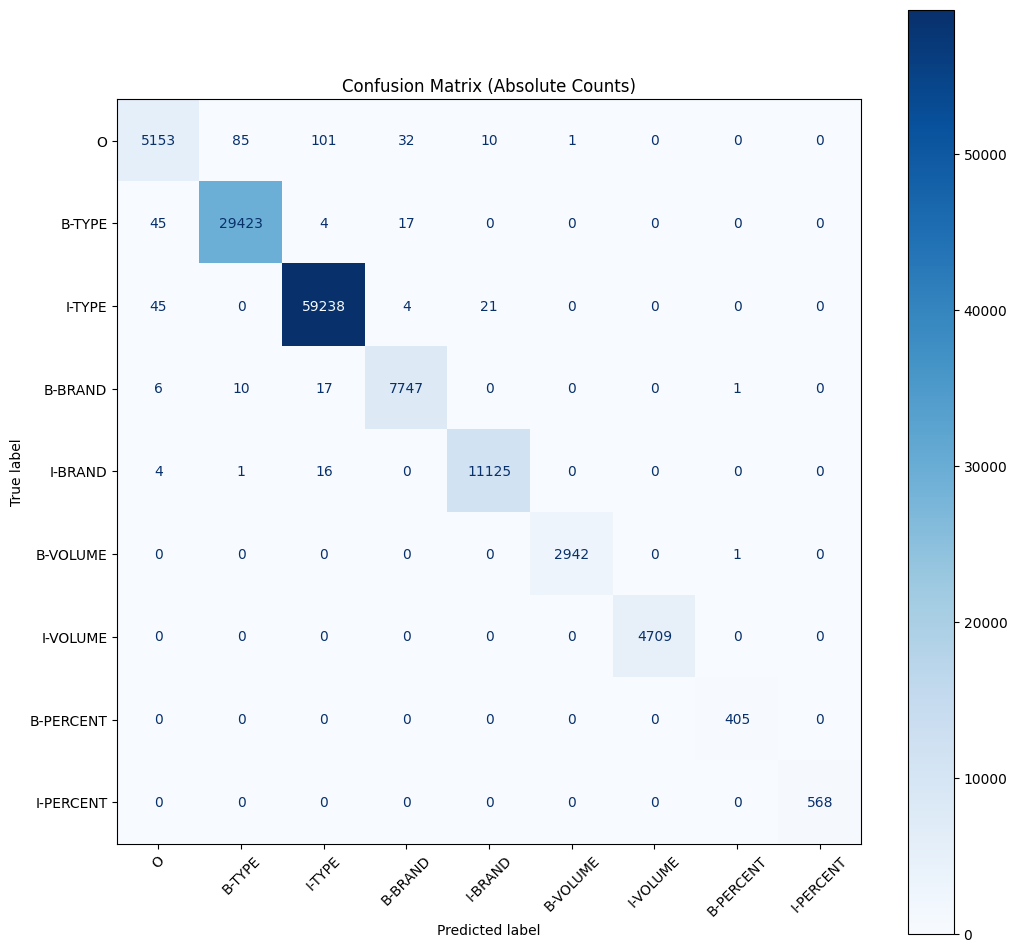

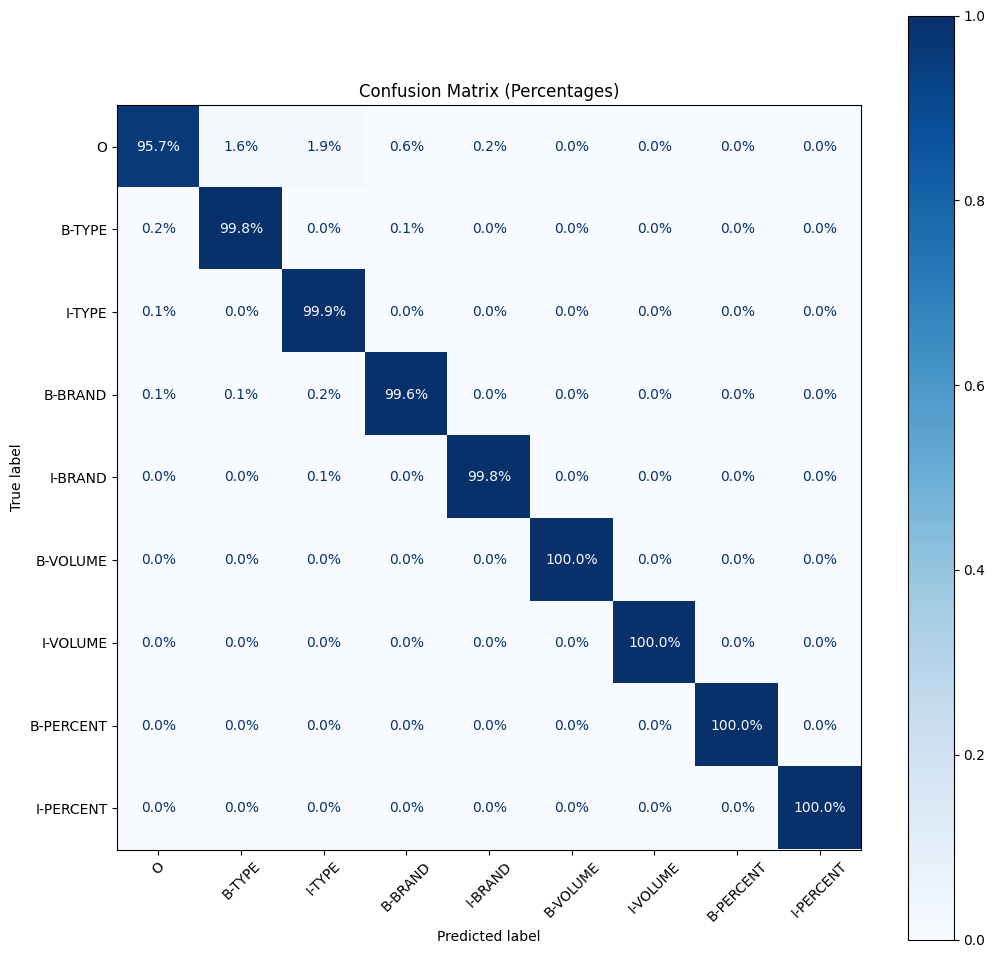

Предсказания сохранены в train_predictions.csv


In [4]:
# -----------------------
# 10) Анализ ошибок
# -----------------------
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Получаем предсказания на всём train_ds
predictions, labels, _ = trainer.predict(train_ds)
preds = np.argmax(predictions, axis=-1)

true_tags, pred_tags = [], []
for i in range(len(labels)):
    for p, l in zip(preds[i], labels[i]):
        if l != -100:  # пропускаем паддинги
            true_tags.append(id2label[int(l)])
            pred_tags.append(id2label[int(p)])

# Матрица ошибок (абсолютные значения)
cm_abs = confusion_matrix(true_tags, pred_tags, labels=LABELS)

fig, ax = plt.subplots(figsize=(12, 12))
disp_abs = ConfusionMatrixDisplay(confusion_matrix=cm_abs, display_labels=LABELS)
disp_abs.plot(ax=ax, cmap="Blues", xticks_rotation=45, values_format="d")
plt.title("Confusion Matrix (Absolute Counts)")
plt.show()

# Матрица ошибок (в процентах, нормализация по строкам)
cm_percent = cm_abs.astype("float") / cm_abs.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(12, 12))
disp_pct = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=LABELS)
disp_pct.plot(ax=ax, cmap="Blues", xticks_rotation=45, values_format=".1%")
plt.title("Confusion Matrix (Percentages)")
plt.show()

# -----------------------
# 11) Сохраняем предсказания на весь train_df
# -----------------------
train_preds = []
for i in range(len(labels)):
    p_seq, l_seq = preds[i], labels[i]
    p_tags, l_tags = [], []
    for p, l in zip(p_seq, l_seq):
        if l != -100:
            p_tags.append(id2label[int(p)])
            l_tags.append(id2label[int(l)])
    train_preds.append({
        "text": train_wl.iloc[i]["text"],
        "true_tags": l_tags,
        "pred_tags": p_tags
    })

preds_df = pd.DataFrame(train_preds)
preds_df.to_csv("train_predictions.csv", index=False, encoding="utf-8-sig", sep=";")
print("Предсказания сохранены в train_predictions.csv")

In [5]:
# Сабмишн для NER (XLM-R)
import os
import gc
import re
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoConfig, AutoModelForTokenClassification

# --------------------------
# Настройки
# --------------------------
MODEL_DIR = "/kaggle/working/ner_xlmr_wordlevel_entity_best"
SUBMISSION_PATH = "/kaggle/input/1-million-clen-aug-correct-coffee/1_million_clen_aug_correct_coffee/submission.csv"
OUTPUT_PATH = "/kaggle/working/submission_final_fixed_base.csv"   # ← Excel
MAX_LENGTH = 512
BATCH_SIZE = 8

# --------------------------
# Жёсткие регулярки
# --------------------------
NUM = r'\d+(?:[.,]\d+)?'
UNIT = (
    r'(?:'
    r'л(?:\.)?|литр[а-я]*|мл(?:\.)?|'
    r'кг(?:\.)?|г(?:рамм)?|гр(?:амм)?|'
    r'шт(?:ук)?|рулон[а-я]*|'
    r'пакет(?:ик)?[а-я]*|десяток(?:\s*(?:шт|штук))?'
    r')'
)
VOLUME_RE = re.compile(rf'(?<!\w)(?:{NUM}\s*{UNIT}|{UNIT}\s*{NUM})(?!\w)', re.IGNORECASE)

PWORD = r'(?:%|проц(?:ент)?[а-я]*)'
PERCENT_RE = re.compile(rf'(?<!\w)(?:{NUM}\s*{PWORD}|{PWORD}\s*{NUM})(?!\w)', re.IGNORECASE)

# --------------------------
# Утилиты
# --------------------------
def to_id2label(cfg) -> dict:
    id2label = cfg.id2label
    sample_key = next(iter(id2label.keys()))
    if isinstance(sample_key, str):
        id2label = {int(k): v for k, v in id2label.items()}
    return id2label

def decode_bio_full(pred_ids, offsets, word_ids, id2label):
    entities = []
    word_preds = {}
    for pid, (s, e), wid in zip(pred_ids, offsets, word_ids):
        if wid is None or s == e:
            continue
        label = id2label[int(pid)]
        if wid not in word_preds:
            word_preds[wid] = {"labels": [label], "start": s, "end": e}
        else:
            word_preds[wid]["labels"].append(label)
            word_preds[wid]["end"] = e

    for wid in sorted(word_preds.keys()):
        info = word_preds[wid]
        labels = info["labels"]
        s, e = info["start"], info["end"]
        if any(l.startswith("B-") for l in labels):
            final_label = next(l for l in labels if l.startswith("B-"))
        elif any(l.startswith("I-") for l in labels):
            final_label = next(l for l in labels if l.startswith("I-"))
        else:
            final_label = "O"
        entities.append((s, e, final_label))
    return entities

def _same_entity_continue(prev_ent, s, target_type, text):
    if not prev_ent or prev_ent[2] == "O":
        return False
    prev_type = prev_ent[2].split("-", 1)[-1]
    if prev_type != target_type:
        return False
    return text[prev_ent[1]:s].strip() == ""

def postprocess_entities(text, entities):
    vol_spans = [(m.start(), m.end()) for m in VOLUME_RE.finditer(text)]
    pct_spans = [(m.start(), m.end()) for m in PERCENT_RE.finditer(text)]

    def inside_any(span_list, s, e):
        for ms, me in span_list:
            if s >= ms and e <= me:
                return True
        return False

    out = []
    for (s, e, label) in entities:
        if label == "O":
            is_pct = inside_any(pct_spans, s, e)
            is_vol = inside_any(vol_spans, s, e)

            if is_pct and not is_vol:
                out.append((s, e, "I-PERCENT" if _same_entity_continue(out[-1] if out else None, s, "PERCENT", text) else "B-PERCENT"))
            elif is_vol and not is_pct:
                out.append((s, e, "I-VOLUME" if _same_entity_continue(out[-1] if out else None, s, "VOLUME", text) else "B-VOLUME"))
            else:
                out.append((s, e, label))
        else:
            out.append((s, e, label))
    return out

def sanitize_bio(entities):
    """
    Чиним: если встречаем I-X, а до этого в строке не было B-X,
    превращаем его в B-X.
    """
    seen_types = set()
    out = []
    for (s, e, label) in entities:
        if label.startswith("B-"):
            seen_types.add(label[2:])
            out.append((s, e, label))
        elif label.startswith("I-"):
            t = label[2:]
            if t not in seen_types:
                # первая встреча этого типа → делаем B-
                label = f"B-{t}"
                seen_types.add(t)
            out.append((s, e, label))
        else:
            out.append((s, e, label))
    return out

@torch.no_grad()
def predict_batch(texts, tokenizer, model, id2label, device):
    enc = tokenizer(
        texts,
        return_tensors="pt",
        return_offsets_mapping=True,
        padding=True,
        truncation=True,
        max_length=MAX_LENGTH,
    )
    offsets = enc.pop("offset_mapping")
    word_ids_batch = [enc.word_ids(i) for i in range(len(texts))]
    input_ids = enc["input_ids"].to(device)
    attention_mask = enc["attention_mask"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    pred = torch.argmax(logits, dim=-1).cpu().numpy()

    all_entities = []
    for i in range(pred.shape[0]):
        ents_raw = decode_bio_full(pred[i], offsets[i].tolist(), word_ids_batch[i], id2label)
        ents_pp = postprocess_entities(texts[i], ents_raw)
        ents_pp = sanitize_bio(ents_pp)   # ← новый шаг
        all_entities.append(ents_pp)

    del enc, input_ids, attention_mask, outputs, logits, pred
    gc.collect()
    if device.type == "cuda":
        torch.cuda.empty_cache()
    return all_entities

def run_inference_and_save():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, use_fast=True)
    config = AutoConfig.from_pretrained(MODEL_DIR)
    id2label = to_id2label(config)

    model = AutoModelForTokenClassification.from_pretrained(MODEL_DIR)
    model.to(device)
    model.eval()

    df = pd.read_csv(SUBMISSION_PATH, sep=";", encoding="utf-8")
    if "annotation" not in df.columns:
        df["annotation"] = ""

    texts = df["sample"].fillna("").tolist()
    n = len(texts)
    print(f"Всего примеров: {n}")

    all_pred_ents = []
    for start in range(0, n, BATCH_SIZE):
        end = min(start + BATCH_SIZE, n)
        batch_texts = texts[start:end]
        batch_ents = predict_batch(batch_texts, tokenizer, model, id2label, device)
        all_pred_ents.extend(batch_ents)
        if start % 500 == 0:
            print(f"Обработано {end}/{n}")

    df["annotation"] = [str(ents) for ents in all_pred_ents]
    df[["sample", "annotation"]].to_csv(OUTPUT_PATH, index=False, sep=";", encoding="utf-8-sig")
    print(f"✅ Сабмишн сохранён в {OUTPUT_PATH}")
    print(df.head(5).to_string(index=False))

# Запуск
run_inference_and_save()

Device: cuda
Всего примеров: 5000
Обработано 8/5000
Обработано 1008/5000
Обработано 2008/5000
Обработано 3008/5000
Обработано 4008/5000
✅ Сабмишн сохранён в /kaggle/working/submission_final_fixed_base.csv
                   sample                                                               annotation
        форма для выпечки                 [(0, 5, 'B-TYPE'), (6, 9, 'I-TYPE'), (10, 17, 'I-TYPE')]
              фарш свиной                                    [(0, 4, 'B-TYPE'), (5, 11, 'I-TYPE')]
сок ананасовый без сахара [(0, 3, 'B-TYPE'), (4, 14, 'I-TYPE'), (15, 18, 'O'), (19, 25, 'I-TYPE')]
                   еринги                                                       [(0, 6, 'B-TYPE')]
                  молооко                                                       [(0, 7, 'B-TYPE')]


In [6]:
import subprocess

# Сохраним список всех установленных пакетов с версиями
subprocess.check_call("pip freeze > requirements_kaggle.txt", shell=True)

print("Список пакетов сохранён в requirements_kaggle.txt")

Список пакетов сохранён в requirements_kaggle.txt
